# Quantum benchmark

## I - Introduction

## II - Packages

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score, KFold
#Import classical libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt

plt.style.use('ggplot')

import functools

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data
import logging

import pennylane as qml
from pennylane.templates.embeddings import AngleEmbedding, AmplitudeEmbedding
from pennylane.optimize import AdamOptimizer

from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
import qiskit

In [80]:
import warnings
warnings.filterwarnings('ignore')

## III - Data 

In [81]:
# Read out CSV

df = pd.read_csv('fraud_detection_bank_dataset.csv', sep=',')

In [82]:
df.columns

Index(['Unnamed: 0', 'col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5',
       'col_6', 'col_7', 'col_8',
       ...
       'col_103', 'col_104', 'col_105', 'col_106', 'col_107', 'col_108',
       'col_109', 'col_110', 'col_111', 'targets'],
      dtype='object', length=114)

In [83]:
df['Unnamed: 0']

0            0
1            1
2            2
3            3
4            4
         ...  
20463    20463
20464    20464
20465    20465
20466    20466
20467    20467
Name: Unnamed: 0, Length: 20468, dtype: int64

In [84]:
df.shape

(20468, 114)

In [3]:
%%script false --no-raise-error

import sweetviz as sv

#EDA using Autoviz
sweet_report = sv.analyze(df)

#Saving results to HTML file
sweet_report.show_html('sweet_report.html')

## IV - Modelisation

### Classical

In [85]:
df = df.drop(['Unnamed: 0'], axis = 1)
df_labels = df['targets']
df.drop(['targets'],axis = 1,inplace = True)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(df, df_labels, test_size=0.2, random_state=42)

### Decision Tree

In [87]:
decision_tree = DecisionTreeClassifier( random_state=42) #max_depth=2,

decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

In [88]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      3025
           1       0.82      0.80      0.81      1069

    accuracy                           0.90      4094
   macro avg       0.87      0.87      0.87      4094
weighted avg       0.90      0.90      0.90      4094



### RandomForest

In [89]:
classifier = RandomForestClassifier( random_state=42) #max_depth=2,

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [90]:
# Print the classification report and important metrics

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      3025
           1       0.92      0.82      0.87      1069

    accuracy                           0.93      4094
   macro avg       0.93      0.90      0.91      4094
weighted avg       0.93      0.93      0.93      4094



### Logistic Regression

In [91]:
lr = LogisticRegression(max_iter=1000, random_state=42) #max_depth=2,

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [92]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      3025
           1       0.70      0.48      0.57      1069

    accuracy                           0.81      4094
   macro avg       0.77      0.70      0.72      4094
weighted avg       0.80      0.81      0.80      4094



### SVM

In [93]:
svm = SVC( random_state=42) #max_depth=2,

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [94]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      1.00      0.85      3025
           1       0.00      0.00      0.00      1069

    accuracy                           0.74      4094
   macro avg       0.37      0.50      0.42      4094
weighted avg       0.55      0.74      0.63      4094



---

## Quantum Approaches

In [95]:
np.unique(df_labels)

array([0, 1])

In [97]:
cols = ['col_8', 'col_9', 'col_10', 'col_11', 'col_12', 'col_18', 'col_19','col_20', 'col_21', 'col_35', 
        'col_51', 'col_52', 'col_53', 'col_70','col_71','col_7', 'col_22', 'col_54', 'col_56']

In [99]:
X_train = X_train.drop(cols, axis=1)
X_test = X_test.drop(cols, axis=1)

In [100]:
np.shape(X_train)

(16374, 93)

In [102]:
lda = LDA(n_components=1)

In [103]:
feature_1 = lda.fit_transform(X_train.iloc[:, :46], y_train)
feature_2 = lda.fit_transform(X_train.iloc[:, 46:], y_train)

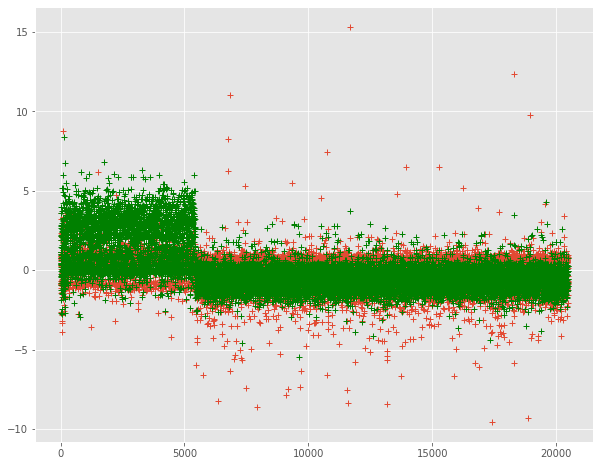

In [104]:
plt.figure(figsize=(10,8))
plt.plot(X_train.index, feature_1, '+')
plt.plot(X_train.index, feature_2, 'g+')

In [105]:
features_lda_1 = pd.DataFrame(feature_1)
features_lda_2 = pd.DataFrame(feature_2)
features_lda = features_lda_1.join(features_lda_2, lsuffix="_left", rsuffix="_right")

In [106]:
n_dim = len(features_lda.columns)

## Split train test 

In [107]:
# Split dataset into train and test

sample_train, sample_test, label_train, label_test = train_test_split(
     features_lda, y_train, test_size=0.2, random_state=22)

# Normalize

std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Scale for better fit within the feature map

samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# Select a sample for a better control of the research and wall time

train_size = 800#160
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 200 #40
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

In [108]:
# Basic parameters for hybrid model

seed = 8500
feature_dim = n_dim
num_reps = 2
num_shots =256 


## Hybrid

In [109]:
# Define feature_map

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=num_reps)

# Define the backend
backend = QuantumInstance(
    BasicAer.get_backend("qasm_simulator"), shots=num_shots, seed_simulator=seed, seed_transpiler=seed
)

# Define the kernel

kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)

# Model run
svc = SVC(kernel=kernel.evaluate)
svc.fit(sample_train, label_train)
score = svc.score(sample_test, label_test)

print(f"Callable kernel classification test score: {score}")

Callable kernel classification test score: 0.89


In [110]:
result_predict = svc.predict(sample_test)

In [111]:
print(metrics.classification_report(label_test,result_predict))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       154
           1       0.96      0.54      0.69        46

    accuracy                           0.89       200
   macro avg       0.92      0.77      0.81       200
weighted avg       0.90      0.89      0.88       200



In [112]:

_models = []
_models.append(('qsvc',svc))
_metrics = ['precision', 'recall', 'f1', 'accuracy', 'balanced_accuracy', 'matthews_corrcoef']
for metric in _metrics:
    df_results= pd.concat([df_results, evaluate_ml_model(_models, sample_train, label_train, n_fold=10, metric=metric)])

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [114]:
df_results.loc['qsvc']

precision mean (%)              NaN
precision std (%)               NaN
recall mean (%)                 NaN
recall std (%)                  NaN
f1 mean (%)                     NaN
f1 std (%)                      NaN
accuracy mean (%)               NaN
accuracy std (%)                NaN
balanced_accuracy mean (%)      NaN
balanced_accuracy std (%)       NaN
matthews_corrcoef mean (%)      NaN
matthews_corrcoef std (%)       NaN
accuracy mean (%)               NaN
accuracy std (%)                NaN
precision mean (%)            95.55
precision std (%)              5.94
recall mean (%)               46.88
recall std (%)                11.47
f1 mean (%)                   61.84
f1 std (%)                    10.31
accuracy mean (%)             85.88
accuracy std (%)               3.16
balanced_accuracy mean (%)    73.03
balanced_accuracy std (%)      5.49
matthews_corrcoef mean (%)    60.34
matthews_corrcoef std (%)      8.08
Name: qsvc, dtype: float64

In [ ]:
df_results[['precision mean (%)', 'precision std (%)', 'recall mean (%)',  'recall std (%)', 'f1 mean (%)', 'f1 std (%)', 
            'matthews_corrcoef mean (%)' , 'matthews_corrcoef std (%)', 'balanced_accuracy mean (%)', 'balanced_accuracy std (%)']]

In [77]:
df_results.columns

Index(['precision mean (%)', 'precision std (%)', 'recall mean (%)',
       'recall std (%)', 'f1 mean (%)', 'f1 std (%)', 'accuracy mean (%)',
       'accuracy std (%)', 'balanced_accuracy mean (%)',
       'balanced_accuracy std (%)', 'matthews_corrcoef mean (%)',
       'matthews_corrcoef std (%)', 'accuracy mean (%)', 'accuracy std (%)',
       'precision mean (%)', 'precision std (%)', 'recall mean (%)',
       'recall std (%)', 'f1 mean (%)', 'f1 std (%)', 'accuracy mean (%)',
       'accuracy std (%)', 'balanced_accuracy mean (%)',
       'balanced_accuracy std (%)', 'matthews_corrcoef mean (%)',
       'matthews_corrcoef std (%)'],
      dtype='object')

In [ ]:
df_results.to_csv('LDA_fraud_dataset.csv')

## Classical Approaches

In [ ]:
models = []
models.append(('LR', LogisticRegression(max_iter=1000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

In [ ]:
df_results = pd.DataFrame()

In [32]:
def evaluate_ml_model(models, X, y, n_fold=10, metric='precision'):
    
    _df = pd.DataFrame()
    #results = []
    names = []
    #scoring = 'accuracy'
    for name, model in models:
        kfold = KFold(n_splits=n_fold)
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring=metric)
        #results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        #print(msg)
        _df =  pd.concat([_df, pd.DataFrame([round(100*cv_results.mean(), 2) , round(100*cv_results.std(), 2) ]).T])
    _df.index = names
    _df.columns=[metric+' mean (%)', metric+' std (%)']
    return _df 
             
        

In [33]:
_metrics = ['precision', 'recall', 'f1', 'accuracy', 'balanced_accuracy', 'matthews_corrcoef']
for metric in _metrics:
    df_results= pd.concat([df_results, evaluate_ml_model(models, sample_train, label_train, n_fold=10, metric=metric)], axis=1)

In [34]:
df_results= pd.concat([df_results, evaluate_ml_model(models, sample_train, label_train, n_fold=10, metric='accuracy')], axis=1)

In [35]:
df_results

,precision mean (%),precision std (%),recall mean (%),recall std (%),f1 mean (%),f1 std (%),accuracy mean (%),accuracy std (%),balanced_accuracy mean (%),balanced_accuracy std (%),matthews_corrcoef mean (%),matthews_corrcoef std (%),accuracy mean (%),accuracy std (%)
LR,97.74,4.72,46.39,11.56,62.00,11.26,86.12,3.37,73.03,5.77,61.17,9.25,86.12,3.37
KNN,76.32,10.86,61.90,11.08,67.60,8.95,85.38,3.06,77.61,5.37,59.38,9.89,85.38,3.06
CART,62.88,10.32,65.07,12.54,63.69,10.09,81.62,4.22,76.08,6.67,52.26,12.99,81.75,4.34
NB,89.69,10.18,51.45,11.66,64.22,9.78,86.00,3.00,74.66,5.51,60.52,8.70,86.00,3.00
SVM,94.55,5.87,49.75,10.29,64.43,9.04,86.50,2.84,74.38,4.97,62.12,7.51,86.50,2.84


## QSVC

In [ ]:
# Be assure that your qiskit version is 0.4.0
# run !pip install --upgrade qiskit==0.4.0 if not 

In [24]:
#%%script false --no-raise-error
# Define feature_map, optimizer and var_form

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)
optimizer = COBYLA(maxiter=20, disp=True, rhobeg=1.0, tol=None)
var_form = TwoLocal(feature_dim, ['ry', 'rz'], 'cz', reps=3)


# Define the backend

#backend = qiskit.Aer.get_backend('qasm_simulator')
backend = BasicAer.get_backend("qasm_simulator")
# Define the instance

quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

# Model run
vqc = QSVC(quantum_kernel=quantum_instance)#optimizer, feature_map, var_form, training_input, test_input, datapoints[0])


result = vqc.fit(sample_train, label_train)



AttributeError: 'QuantumInstance' object has no attribute 'evaluate'

In [1]:
import qiskit
qiskit.__version__

'0.21.1'

In [33]:
!pip3 install --upgrade qiskit #==0.4.0

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


## Pennylane

In [117]:
from pennylane import numpy as np

In [115]:
# Angle Encoding

num_qubits = n_dim

dev = qml.device('default.qubit', wires = num_qubits)

@qml.qnode(dev)
def circuit(parameters, data):
    for i in range(num_qubits):
        qml.Hadamard(wires = i)
    
    AngleEmbedding(features = data, wires = range(num_qubits), rotation = 'Y')
    
    qml.StronglyEntanglingLayers(weights = parameters, wires = range(num_qubits))
    
    return qml.expval(qml.PauliZ(0))

In [118]:
num_layers = 5
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

#print(weights_init, bias_init)

In [119]:
circuit(weights_init, sample_train[0])

tensor(0.01526013, requires_grad=True)

In [120]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [121]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [122]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [123]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [124]:
pd.Series(label_test).value_counts()

0    154
1     46
Name: targets, dtype: int64

In [125]:
Y = np.array(label_train * 2 - np.ones(len(label_train)),requires_grad=True)  # shift label from {0, 1} to {-1, 1}
X = np.array(sample_train, requires_grad=True)

for i in range(5):
    print("X = {}, Y = {: d}".format(list(X[i]), int(Y[i])))

X = [tensor(-0.17272275, requires_grad=True), tensor(-0.09853208, requires_grad=True)], Y = -1
X = [tensor(-0.32162543, requires_grad=True), tensor(-0.24422121, requires_grad=True)], Y = -1
X = [tensor(-0.31270813, requires_grad=True), tensor(-0.23873549, requires_grad=True)], Y = -1
X = [tensor(-0.30648884, requires_grad=True), tensor(-0.32818287, requires_grad=True)], Y = -1
X = [tensor(-0.18793104, requires_grad=True), tensor(-0.39635419, requires_grad=True)], Y = -1


In [126]:
opt = AdamOptimizer(stepsize=0.1, beta1=0.9, beta2=0.99, eps=1e-08)
batch_size = 10

In [65]:
weights = weights_init
bias = bias_init

wbest = 0
bbest = 0
abest = 0
ccost = 0 
for it in range(150):

    # weights update by one optimizer step

    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute the accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    
    '''if accuracy(Y, predictions) > abest:
        wbest = weights
        bbest = bias
        abest = accuracy(Y, predictions)
        print('New best')

    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )'''
    prec = metrics.f1_score(Y, predictions, average='binary', pos_label=1)
    if  prec > abest or ((prec == abest) and (cost(weights, bias, X, Y) < ccost)):
        wbest = weights
        bbest = bias
        abest = prec
        ccost = cost(weights, bias, X, Y)
        print('New best')
    #prec = metrics.precision_score(Y, predictions, average='binary')
    print(
        "Iter: {:5d} | Cost: {:0.7f} | f1: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), prec
        )
    )
    
    

Iter:     1 | Cost: 0.9208959 | f1: 0.0000000 
Iter:     2 | Cost: 0.7946867 | f1: 0.0000000 
Iter:     3 | Cost: 0.7556910 | f1: 0.0000000 
Iter:     4 | Cost: 0.7639409 | f1: 0.0000000 
Iter:     5 | Cost: 0.7921983 | f1: 0.0000000 
Iter:     6 | Cost: 0.7717088 | f1: 0.0000000 
Iter:     7 | Cost: 0.6888074 | f1: 0.0000000 
New best
Iter:     8 | Cost: 0.6455169 | f1: 0.0195122 
New best
Iter:     9 | Cost: 0.6945199 | f1: 0.5054945 
New best
Iter:    10 | Cost: 0.7718919 | f1: 0.6603774 
New best
Iter:    11 | Cost: 0.8019167 | f1: 0.6902174 
Iter:    12 | Cost: 0.7551121 | f1: 0.6539683 
Iter:    13 | Cost: 0.6933104 | f1: 0.5563380 
Iter:    14 | Cost: 0.6378236 | f1: 0.3292181 
Iter:    15 | Cost: 0.6311739 | f1: 0.0000000 
Iter:    16 | Cost: 0.6686313 | f1: 0.0000000 
Iter:    17 | Cost: 0.6661770 | f1: 0.0000000 
Iter:    18 | Cost: 0.6691633 | f1: 0.0000000 
Iter:    19 | Cost: 0.6573301 | f1: 0.0000000 
Iter:    20 | Cost: 0.6221312 | f1: 0.0098039 
Iter:    21 | Cost: 0.61

In [66]:
Yte = np.array(label_test * 2 - np.ones(len(label_test)))
Xte = np.array(normalize(sample_test))

In [67]:
pd.Series(Yte).value_counts()

-1.0    154
 1.0     46
dtype: int64

In [68]:
predictions = [np.sign(variational_classifier(wbest, bbest, x)) for x in Xte]
pred = [np.sign(variational_classifier(wbest, bbest, x)) for x in X]
acc = accuracy(Yte, predictions)

print(f'Cost: {cost(wbest, bbest, Xte, Yte)}, Accuracy: {np.round(acc, 2) * 100}%')

Cost: 0.5369482717759729, Accuracy: 84.0%


In [64]:
print(metrics.classification_report(Yte,predictions))

              precision    recall  f1-score   support

        -1.0       0.80      1.00      0.89       154
         1.0       1.00      0.17      0.30        46

    accuracy                           0.81       200
   macro avg       0.90      0.59      0.59       200
weighted avg       0.85      0.81      0.75       200



In [69]:
print(metrics.classification_report(predictions,Yte))

              precision    recall  f1-score   support

        -1.0       1.00      0.82      0.90       187
         1.0       0.28      1.00      0.44        13

    accuracy                           0.83       200
   macro avg       0.64      0.91      0.67       200
weighted avg       0.95      0.83      0.87       200



In [42]:
print(f'''

    Precision: {round(100*metrics.precision_score(predictions,Yte),2)}%
    Recall: {round(100*metrics.recall_score(predictions,Yte),2)}%
    f1: {round(100*metrics.f1_score(predictions,Yte),2)}%
    Accuracy: {round(100*metrics.accuracy_score(predictions,Yte),2)}%
    Balanced accuracy: {round(100*metrics.balanced_accuracy_score(predictions,Yte),2)}%
    Matthew corcorref: {round(100*metrics.matthews_corrcoef(predictions,Yte),2)}%
    ''')



    Precision: 100.0%
    Recall: 75.41%
    f1: 85.98%
    Accuracy: 92.5%
    Balanced accuracy: 87.7%
    Matthew corcorref: 82.5%
    


In [ ]:
_models = []
_models.append(('qsvc',svc))
_metrics = ['precision', 'recall', 'f1', 'accuracy', 'balanced_accuracy', 'matthews_corrcoef']
for metric in _metrics:
    df_results= pd.concat([df_results, evaluate_ml_model(_models, sample_train, label_train, n_fold=10, metric=metric)], axis=1)

In [131]:
weights = weights_init
bias = bias_init

wbest = 0
bbest = 0
abest = 0
ccost = 1 
for it in range(150):

    # weights update by one optimizer step

    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute the accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    
    '''if accuracy(Y, predictions) > abest:
        wbest = weights
        bbest = bias
        abest = accuracy(Y, predictions)
        print('New best')

    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )'''
    prec = metrics.f1_score(Y, predictions, average='binary', pos_label=1)
    if  prec > abest or ((prec == abest) and (cost(weights, bias, X, Y) < ccost)):
        wbest = weights
        bbest = bias
        abest = prec
        ccost = cost(weights, bias, X, Y)
        print('New best')
    #prec = metrics.precision_score(Y, predictions, average='binary')
    print(
        "Iter: {:5d} | Cost: {:0.7f} | f1: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), prec
        )
    )
    
    

New best
Iter:     1 | Cost: 0.9403284 | f1: 0.0000000 
New best
Iter:     2 | Cost: 0.7799214 | f1: 0.0000000 
New best
Iter:     3 | Cost: 0.7670495 | f1: 0.0000000 
Iter:     4 | Cost: 0.7741671 | f1: 0.0000000 
New best
Iter:     5 | Cost: 0.7461181 | f1: 0.0000000 
New best
Iter:     6 | Cost: 0.6853951 | f1: 0.0000000 
New best
Iter:     7 | Cost: 0.6467734 | f1: 0.0000000 
New best
Iter:     8 | Cost: 0.6293619 | f1: 0.0098039 
New best
Iter:     9 | Cost: 0.6341493 | f1: 0.1028037 
New best
Iter:    10 | Cost: 0.6434149 | f1: 0.1955556 
Iter:    11 | Cost: 0.6327404 | f1: 0.1116279 
Iter:    12 | Cost: 0.6254117 | f1: 0.0000000 
Iter:    13 | Cost: 0.6236002 | f1: 0.0666667 
New best
Iter:    14 | Cost: 0.6561912 | f1: 0.4000000 
New best
Iter:    15 | Cost: 0.6608916 | f1: 0.4661654 
Iter:    16 | Cost: 0.6361108 | f1: 0.3360656 
Iter:    17 | Cost: 0.6114903 | f1: 0.0666667 
Iter:    18 | Cost: 0.6397880 | f1: 0.0000000 
Iter:    19 | Cost: 0.7005492 | f1: 0.0000000 
Iter:   

In [132]:
predictions = [np.sign(variational_classifier(wbest, bbest, x)) for x in Xte]
pred = [np.sign(variational_classifier(wbest, bbest, x)) for x in X]
acc = accuracy(Yte, predictions)

print(f'Cost: {cost(wbest, bbest, Xte, Yte)}, Accuracy: {np.round(acc, 2) * 100}%')

Cost: 0.4763296226792806, Accuracy: 86.0%


In [133]:
print(metrics.classification_report(Yte, predictions))

              precision    recall  f1-score   support

        -1.0       0.85      1.00      0.92       154
         1.0       1.00      0.41      0.58        46

    accuracy                           0.86       200
   macro avg       0.93      0.71      0.75       200
weighted avg       0.89      0.86      0.84       200



In [134]:
print(f'''

    Precision: {round(100*metrics.precision_score(predictions,Yte),2)}%
    Recall: {round(100*metrics.recall_score(predictions,Yte),2)}%
    f1: {round(100*metrics.f1_score(predictions,Yte),2)}%
    Accuracy: {round(100*metrics.accuracy_score(predictions,Yte),2)}%
    Balanced accuracy: {round(100*metrics.balanced_accuracy_score(predictions,Yte),2)}%
    Matthew corcorref: {round(100*metrics.matthews_corrcoef(predictions,Yte),2)}%
    ''')



    Precision: 41.3%
    Recall: 100.0%
    f1: 58.46%
    Accuracy: 86.5%
    Balanced accuracy: 92.54%
    Matthew corcorref: 59.28%
    
